In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


AttributeError: module 'matplotlib' has no attribute 'get_data_path'

### Подгрузка данных 

In [ ]:
# Токенизатор разбивает текст на слова и пунктуацию 
tokenizer = WordPunctTokenizer() 
 
def tokenize(x):
  # Приводит текст к нижнему регистру и разделяет текст на слова и символы пунктуации 
  return ' '.join(tokenizer.tokenize(x.lower())) 

### BPE

In [ ]:
with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
  # Цикл проходит по каждой строке файла
  for line in open('data.txt', encoding='utf-8'): \
    # разделяем русс и англ текст с помощью табуляции (\t)
    src_line, dst_line = line.strip().split('\t') 
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [ ]:
bpe = {} # словарь для хранения BPE
# Цикл сначала обрабатывает англ текст, а потом русский
for lang in ['en', 'ru']: 
    learn_bpe(open('./train.' + lang, encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=8000) # обучаем правила bpe на тексте (num_symbols - кол-во BPE пар, которые нужно создать)
    bpe[lang] = BPE(open('./bpe_rules.' + lang)) # объект BPE, загружающий обученные правила из файла 

    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n') # применяем правила BPE к строке и записываем её в train.bpe

100%|██████████| 8000/8000 [00:08<00:00, 917.20it/s] 


В этом куске кода в файл bpe_rules записываются пары символов, после чего они применяются для исходного файла

### Построение словарей

In [ ]:
data_inp = np.array(open('./train.bpe.ru', encoding='utf-8').read().split('\n')) # массив списка строк на русском
data_out = np.array(open('./train.bpe.en', encoding='utf-8').read().split('\n')) # массив списка строк на англ

train_inp, dev_inp, train_out, dev_out = train_test_split( # разделение на обучающую и тестовую выборки
    data_inp, # входные данные (русский текст)
    data_out, # выходные данные (английский текст)
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: э@@ т@@ о@@ т о@@ т@@ е@@ л@@ ь н@@ а@@ х@@ о@@ д@@ и@@ т@@ с@@ я в ц@@ е@@ н@@ т@@ р@@ е п@@ а@@ р@@ и@@ ж@@ а , в 2 м@@ и@@ н@@ у@@ т@@ а@@ х о@@ т п@@ л@@ о@@ щ@@ а@@ д@@ и р@@ е@@ с@@ п@@ у@@ б@@ л@@ и@@ к@@ и и с@@ т@@ а@@ н@@ ц@@ и@@ и м@@ е@@ т@@ р@@ о с 5 л@@ и@@ н@@ и@@ я@@ м@@ и м@@ е@@ т@@ р@@ о и 4 а@@ в@@ т@@ о@@ б@@ у@@ с@@ н@@ ы@@ м@@ и м@@ а@@ р@@ ш@@ р@@ у@@ т@@ а@@ м@@ и .
out: this hotel is located in the centre of paris , 2 minutes from place de la r@@ é@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: н@@ а п@@ о@@ л@@ н@@ о@@ с@@ т@@ ь@@ ю о@@ б@@ о@@ р@@ у@@ д@@ о@@ в@@ а@@ н@@ н@@ о@@ й м@@ и@@ н@@ и - к@@ у@@ х@@ н@@ е м@@ о@@ ж@@ н@@ о с@@ а@@ м@@ о@@ с@@ т@@ о@@ я@@ т@@ е@@ л@@ ь@@ н@@ о г@@ о@@ т@@ о@@ в@@ и@@ т@@ ь .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: н@@ о@@ м@@ е@@ р@@ а н@@ а@@ х@@ о@@ д@@ я@@ т@@ с@@ я п@@ о@@ д к@@ р@@ ы@@ ш@@ е@@ й и@@ л@@ и н@@ а н@@

In [ ]:
from vocab import Vocab 
inp_voc = Vocab.from_lines(train_inp) # создаём объект Vocab из русского текста
out_voc = Vocab.from_lines(train_out) # создаём объект Vocab из англ текста 
batch_lines = sorted(train_inp, key=len)[5:10] # сортируем строки русского текста по длине, и выбираем только строки с 5 по 10
batch_ids = inp_voc.to_matrix(batch_lines) # преобразуем эти строки в матрицу индексов 
batch_lines_restored = inp_voc.to_lines(batch_ids) # преобразуем матрицу обратно в строки 

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['о@@ т@@ к@@ р@@ ы@@ т б@@ а@@ р .', 'д@@ о ш@@ у@@ о@@ л@@ я - 27 к@@ м .', 'д@@ о т@@ у@@ а@@ п@@ с@@ е 19 к@@ м .', 'д@@ о л@@ у@@ в@@ р@@ а — 1 , 8 к@@ м .', 'д@@ о р@@ а@@ в@@ е@@ н@@ н@@ ы 29 к@@ м .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 1627, 1635, 1619, 1631, 1653, 1634, 1601, 1599, 1630,   29,    1,
            1,    1,    1,    1],
        [   0, 1607, 1626, 1647, 1637, 1627, 1621, 1660,   27,   69, 1619, 1622,
           29,    1,    1,    1],
        [   0, 1607, 1626, 1635, 1637, 1599, 1629, 1633, 1608,   55, 1619, 1622,
           29,    1,    1,    1],
        [   0, 1607, 1626, 1621, 1637, 1603, 1631, 1598, 1666,   37,   25,  135,
         1619, 1622,   29,    1],
        [   0, 1607, 1626, 1631, 1599, 1603, 1609, 1625, 1625, 1652,   71, 1619,
         1622,   29,    1,    1]])

back to words
['о@@ т@@ к@@ р@@ ы@@ т б@@ а@@ р .', 'д@@ о ш@@ у@@ о@@ л@@ я - 27 к@@ м .', 'д@@ о т@@ у@@ а@@ п@@ с@@ е 19 к@@ м .', 'д@@ о л@@ у@@ в@@ р@@ а — 1 , 8 к@@ м .

### Распределения длин исходных текстов и переводов

(array([5.6300e+02, 8.8530e+03, 1.1836e+04, 1.1081e+04, 6.2210e+03,
        3.9950e+03, 2.4600e+03, 1.0420e+03, 4.8600e+02, 2.3600e+02,
        1.3100e+02, 5.5000e+01, 1.5000e+01, 1.1000e+01, 6.0000e+00,
        2.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0. ,   5.3,  10.6,  15.9,  21.2,  26.5,  31.8,  37.1,  42.4,
         47.7,  53. ,  58.3,  63.6,  68.9,  74.2,  79.5,  84.8,  90.1,
         95.4, 100.7, 106. ]),
 <BarContainer object of 20 artists>)

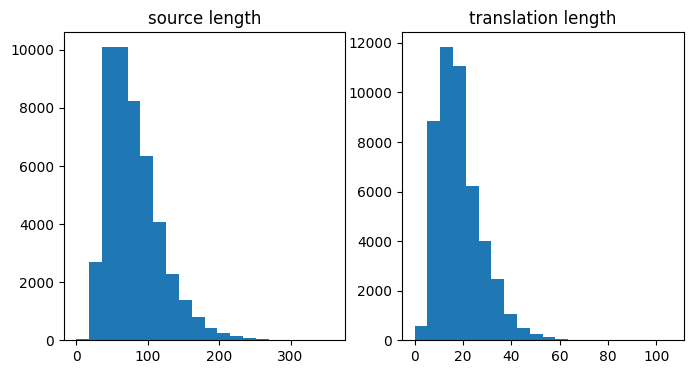

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20) # распределение количества строк

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20)

### Loss

Категориальная кросс-энтропия - это метрика, используемая в машинном обучении для оценки точности модели, когда нужно предсказать несколько классов (категорий). Эта метрика сравнивает предсказанные вероятности для каждого класса с фактическими значениями и вычисляет, насколько они отличаются друг от друга. Чем меньше значение категориальной кросс-энтропии, тем лучше модель справляется с задачей классификации.

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Вычислите потери (скаляр float32), как в формуле выше.
    :param inp: матрица входных токенов, int32[пакет, время]
    :param out: матрица ссылочных токенов, int32[пакет, время]

    Чтобы пройти тесты, ваша функция должна
    * включать потери на первом EOS, но не на последующих
    * разделить сумму потерь на сумму входных длин (используйте voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len] создает маску, которая указывает, какие токены должны учитываться при расчете потерь
    # Важно, чтобы потери включали первый токен EOS, но игнорировали последующие
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32) # преобразуем целевые токены в one-hot вектора, где длина каждого вектора = размеру словаря model.out_voc

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out) # модель на основе inp и out возвращает последовательность логитов, предсказанных для каждого шага

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1) # вычисляем логарифм вероятностей для всех токенов, применяя log_softmax к логитам, вычесленным моделью

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) 
    """ 
    Умножение логарифмированных вероятностей на one-hot векторы целей позволяет выбрать логарифм вероятности только для актуальных токенов. Суммирование по последнему измерению оставляет одно значение на каждый шаг в каждом примере батча.
    """
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    """ 
    -logp_out[mask]: Использует ранее созданную маску для выбора значений логарифма вероятностей, которые должны учитываться при расчете потерь. Знак минус необходим, так как потери - это отрицательный логарифм вероятности.
    .mean(): Среднее значение по всем выбранным потерям дает итоговую величину потерь для текущего батча.
    """
    return -logp_out[mask].mean()

### Оценка качества: BLEU


BLEU (Bilingual Evaluation Understudy) - это метрика, используемая для оценки качества машинного перевода. Она оценивает степень соответствия машинного перевода эталонному (человеческому) переводу путем сравнения пересечения n-грамм в предложениях машинного и эталонного переводов. Значение BLEU на валидационном наборе данных дает представление о том, насколько хорошо модель переводит текст на данных, которые она не видела в процессе обучения. Чем ближе значение BLEU к 1, тем лучше качество перевода с точки зрения этой метрики.

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]

        smoothie = SmoothingFunction().method1  # Использование стандартного метода сглаживания из nltk
        return corpus_bleu(
            [[ref.split()] for ref in actual], 
            [trans.split() for trans in translations],
            smoothing_function=smoothie
        ) * 100

# Задание: Применить любые два метода улучшения из представленных:
1) использовать различные RNN юниты: rnn/gru/lstm; более глубокие архитектуры
2) Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head)
3) word dropout, sheduling
4) заменить greedy инференс на beam search

## 1 Использовать различные RNN юниты: rnn/gru/lstm; более глубокие архитектуры

Чтобы использовать различные RNN юниты добавим в конструктор класса выбор юнита, а в конце сравним их качество

In [ ]:
# Если на утройстве доступна CUDA, будем обучать на неё (или же GPU), иначе на CPU 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [ ]:
# Самая простая модель вида энкодер-декодер seq2seq
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, rnn_type, emb_size=64, hid_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        # Выбор RNN юнита
        if rnn_type == 'lstm':
            RNNUnit = nn.LSTM
        elif rnn_type == 'rnn':
            RNNUnit = nn.RNN
        else:
            RNNUnit = nn.GRU
        self.enc0 = RNNUnit(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    # функция чтобы применить модель в режиме обучения
    # сначала энкодер кодирует данные, потом декодер их декодирует
    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    # закодировать (вычеслить начальное состояние) 
    # inp - матрица входных токенов, возвращает тензоры начального состояния декодера
    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp) # преобразует входные индексы в векторы с помощью слоя эмбеддинга
        batch_size = inp.shape[0] # получает размер батча из входный данных
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # last_state на самом деле не является последним из-за заполнения, давайте найдем реальное last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # last_state: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]


    # Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логит для следующих токенов
    # :параметр prev_state: список тензоров предыдущего состояния декодера, такой же, как возвращается encode(...)
    # :параметр prev_tokens: предыдущие выходные токены, вектор int [batch_size]
    # :возвращает: список тензоров следующего состояния декодера, тензор логитов [batch, len(out_voc)]
    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0] # получили предыдущее состояние GRU
        prev_emb = self.emb_out(prev_tokens) # эмбеддинг предыдущих токенов
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # обновляем состояние декодера (используем эмбеддинги и предыдущее состояние)
        output_logits = self.logits(new_dec_state) # преобразует новое состояние декодера в логиты, которые представляют собой ненормализованные вероятности следубщего токена 
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        # начальные логиты: всегда предсказывайте БОС
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    # Генерировать переводы из модели (жадная версия)
    def decode_inference(self, initial_state, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

Для начала запустим модель, используя GRU

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 

model = BasicModel(inp_voc, out_voc, 'gru').to(device) 
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)
batch_size = 32

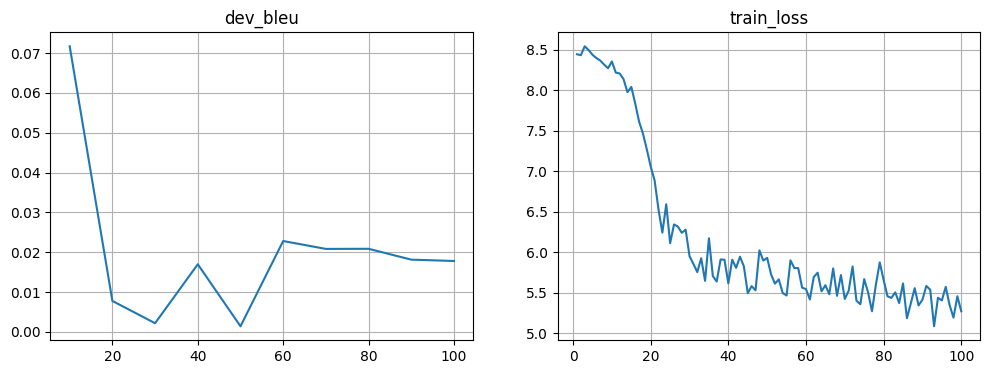

Mean loss=5.388


100%|██████████| 100/100 [05:17<00:00,  3.17s/it]


In [ ]:
for _ in trange(100):
    step = len(metrics['train_loss']) + 1 # текущий шаг обучения
    batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device) 

    opt.zero_grad() # обнуляет градиенты для новой итерации
    loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
    loss_t.backward() # вычисляем градиенты
    opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

    metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

    if step % 10 == 0: # каждые 10 шагов 
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out))) # добавляем значение BLUE

        clear_output(True) # очищает вывод консоли
        plt.figure(figsize=(12,4))
        # строим график для каждой метрики
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.017794590812022705

Далее сравним предыдущую модель с моделью, которая будет использовать RNN

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 

model = BasicModel(inp_voc, out_voc, 'rnn').to(device) 
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)
batch_size = 32

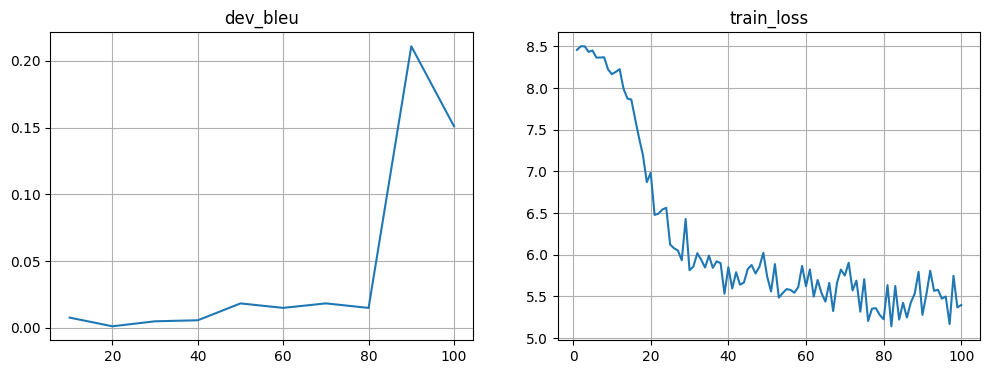

Mean loss=5.513


100%|██████████| 100/100 [04:27<00:00,  2.68s/it]


In [ ]:
for _ in trange(100):
    step = len(metrics['train_loss']) + 1 # текущий шаг обучения
    batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad() # обнуляет градиенты для новой итерации
    loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
    loss_t.backward() # вычисляем градиенты
    opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

    metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

    if step % 10 == 0: # каждые 10 шагов 
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out))) # добавляем значение BLUE

        clear_output(True) # очищает вывод консоли
        plt.figure(figsize=(12,4))
        # строим график для каждой метрики
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.15105937480347156

Теперь посмотрим модель с использованием LSTM

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 

model = BasicModel(inp_voc, out_voc, 'lstm').to(device) 
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)
batch_size = 32

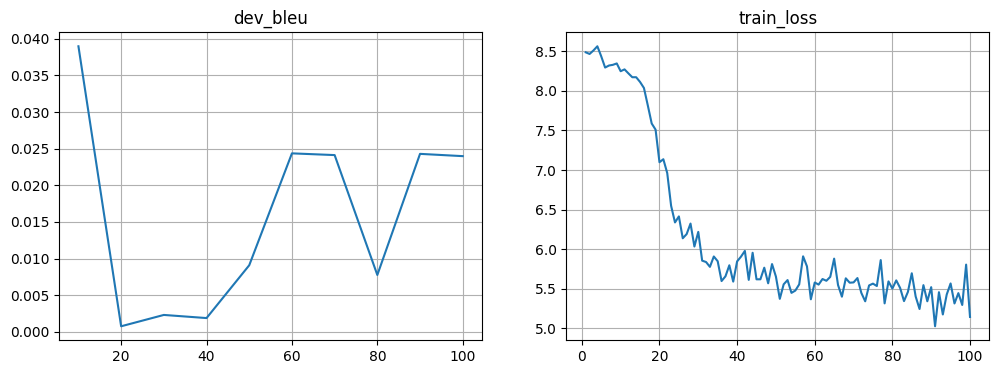

Mean loss=5.366


100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


In [ ]:
for _ in trange(100):
    step = len(metrics['train_loss']) + 1 # текущий шаг обучения
    batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad() # обнуляет градиенты для новой итерации
    loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
    loss_t.backward() # вычисляем градиенты
    opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

    metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

    if step % 10 == 0: # каждые 10 шагов 
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out))) # добавляем значение BLUE

        clear_output(True) # очищает вывод консоли
        plt.figure(figsize=(12,4))
        # строим график для каждой метрики
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.023978980400973206

Получаем, что для выборки в 100 проходов цикла, метрика BLUE модели с использованием LSTM равна (0.036), с использованием RNN равна (0.259), а с использованием GRU равна (0.036)

Чтобы использовать более глубокие архитектуры, добавим к энкодеру и декодеру несколько слоев. Так как до этого мы проанализировали различные юниты, будем использовать RNN, так как он самый лучший

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, num_layers=2):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.RNN(emb_size, hid_size, num_layers=num_layers, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    # функция чтобы применить модель в режиме обучения
    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)
    
    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    # # закодировать (вычеслить начальное состояние) 
    # # inp - матрица входных токенов, возвращает тензоры начального состояния декодера
    # def encode(self, inp, **flags):
    #     inp_emb = self.emb_inp(inp)
    #     enc_seq, last_state = self.enc0(inp_emb) 
    #     # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size] 
    #     # last_state на самом деле не является последним из-за заполнения, давайте найдем реальное last_state
    #     lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
    #     last_state = last_state[-1]  
    #     # last_state: [batch_size, hid_size]
    #     dec_start = self.dec_start(last_state)
    #     return [dec_start]

    # Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логит для следующих токенов
    # :параметр prev_state: список тензоров предыдущего состояния декодера, такой же, как возвращается encode(...)
    # :параметр prev_tokens: предыдущие выходные токены, вектор int [batch_size]
    # :возвращает: список тензоров следующего состояния декодера, тензор логитов [batch, len(out_voc)]
    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)
    
    # Генерировать переводы из модели (жадная версия)
    def decode_inference(self, initial_state, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 

model = BasicModel(inp_voc, out_voc).to(device) 
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)
batch_size = 32

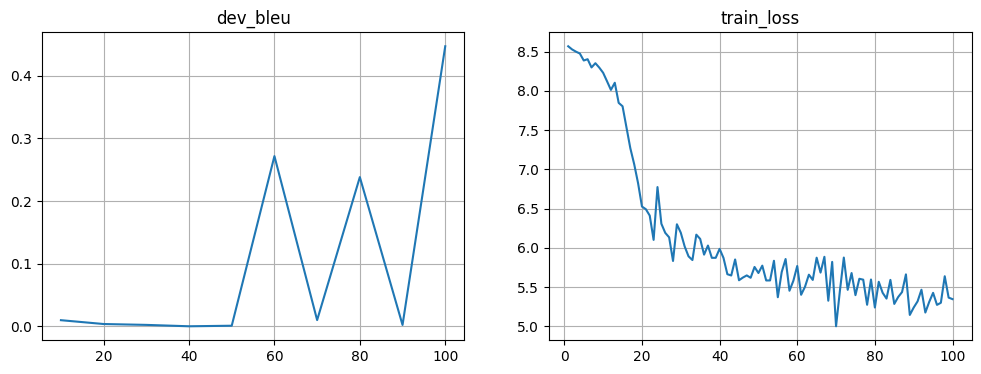

Mean loss=5.364


100%|██████████| 100/100 [05:09<00:00,  3.09s/it]


In [ ]:
for _ in trange(100):
    step = len(metrics['train_loss']) + 1 # текущий шаг обучения
    batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad() # обнуляет градиенты для новой итерации
    loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
    loss_t.backward() # вычисляем градиенты
    opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

    metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

    if step % 10 == 0: # каждые 10 шагов 
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out))) # добавляем значение BLUE

        clear_output(True) # очищает вывод консоли
        plt.figure(figsize=(12,4))
        # строим график для каждой метрики
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.4468477115074143

## 2 word dropout, sheduling

### word dropout

In [ ]:
class BasicModelWithDropout(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.RNN(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def apply_word_dropout(self, input_tensor, dropout_rate=0.1, unk_idx=0):
        mask = torch.rand(input_tensor.shape, device=input_tensor.device) < dropout_rate # вычисляем маску (тензор)
        input_tensor[mask] = unk_idx # накладывает маску на тензор 
        return input_tensor 
    
    # ПРИМЕР
    # Сегодня хорошая погода ура !
    # mask = [0, 4]
    # unk хорошая погода ура unk

    # закодировать (вычеслить начальное состояние) 
    # inp - матрица входных токенов, возвращает тензоры начального состояния декодера
    def encode(self, inp, **flags):
        # Применение Word Dropout перед эмбеддингом
        inp = self.apply_word_dropout(inp, dropout_rate=0.1, unk_idx=self.inp_voc.unk_ix)
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1)
        lengths = (lengths - 1).clamp(min=0)
        forward_states = enc_seq[torch.arange(batch_size), lengths, :self.hid_size]
        backward_states = enc_seq[:, 0, self.hid_size:]
        last_state = torch.cat([forward_states, backward_states], dim=-1)
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)
    
    # Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логит для следующих токенов
    # :параметр prev_state: список тензоров предыдущего состояния декодера, такой же, как возвращается encode(...)
    # :параметр prev_tokens: предыдущие выходные токены, вектор int [batch_size]
    # :возвращает: список тензоров следующего состояния декодера, тензор логитов [batch, len(out_voc)]  
    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits

    # Генерировать переводы из модели (жадная версия)
    def decode_inference(self, initial_state, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]
        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        return torch.stack(outputs, dim=1), all_states
    
    def translate_lines(self, inp_lines, **kwargs): # переводит входные строки 
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 

model = BasicModelWithDropout(inp_voc, out_voc).to(device) 
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)
batch_size = 32

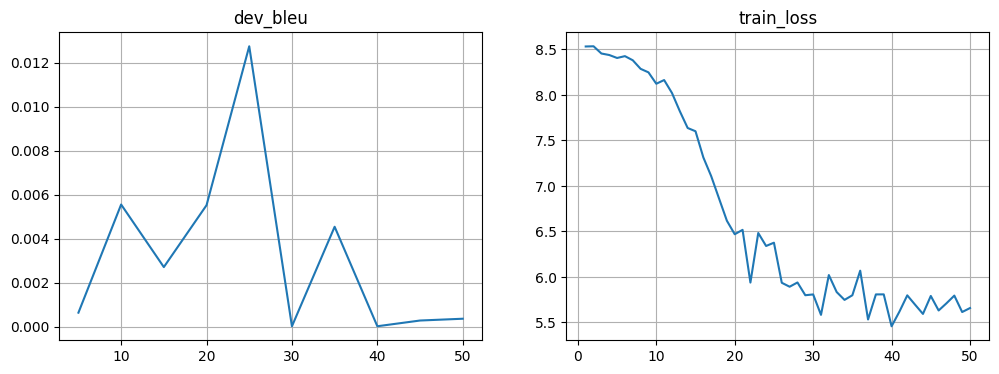

Mean loss=5.691


100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


In [ ]:
for _ in trange(50):
    step = len(metrics['train_loss']) + 1 # текущий шаг обучения
    batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad() # обнуляет градиенты для новой итерации
    loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
    loss_t.backward() # вычисляем градиенты
    opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

    metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

    if step % 5 == 0: # каждые 5 шагов 
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out))) # добавляем значение BLUE

        clear_output(True) # очищает вывод консоли
        plt.figure(figsize=(12,4))
        # строим график для каждой метрики
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.00036794313065984413

### sheduling

In [ ]:
import random

In [ ]:
class BasicModelWithSheduling(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, max_dropout_rate=0.1, decay_steps=10000):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.global_step = 0
        self.max_dropout_rate = max_dropout_rate
        self.decay_steps = decay_steps

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        self.enc0 = nn.RNN(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def apply_scheduled_dropout(self, input_tensor, unk_idx=0):
        dropout_rate = self.max_dropout_rate * (1 - self.global_step / self.decay_steps) # рандомный шанс применения дропаута
        dropout_rate = max(dropout_rate, 0)  # 0, если шанс будет отрицательтым
        mask = torch.rand(input_tensor.shape, device=input_tensor.device) < dropout_rate # маска (тензор)
        input_tensor[mask] = unk_idx # накладываем маску
        return input_tensor

    # закодировать (вычеслить начальное состояние) 
    # inp - матрица входных токенов, возвращает тензоры начального состояния декодера
    def encode(self, inp, **flags):
        # Применение Scheduled Dropout перед эмбеддингом
        inp = self.apply_scheduled_dropout(inp, unk_idx=self.inp_voc.unk_ix)
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1)
        lengths = (lengths - 1).clamp(min=0)
        forward_states = enc_seq[torch.arange(batch_size), lengths, :self.hid_size]
        backward_states = enc_seq[:, 0, self.hid_size:]
        last_state = torch.cat([forward_states, backward_states], dim=-1)
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def forward(self, inp, out):
        if self.training:
            self.global_step += 1
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    # Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логит для следующих токенов
    # :параметр prev_state: список тензоров предыдущего состояния декодера, такой же, как возвращается encode(...)
    # :параметр prev_tokens: предыдущие выходные токены, вектор int [batch_size]
    # :возвращает: список тензоров следующего состояния декодера, тензор логитов [batch, len(out_voc)]
    def decode_step(self, prev_state, prev_tokens, **flags):
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits
    
    def decode_inference(self, initial_state, max_len=100, **flags): # генерация входной последовательности в режиме ввода (inference)  
        """Генерация переводов из модели (жадная версия)"""
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len): 
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states
    
    def translate_lines(self, inp_lines, **kwargs): # переводит входные строки 
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] } # список со значениями потерь на обучающей выборке и BLEU-оценка 

model = BasicModelWithSheduling(inp_voc, out_voc).to(device) 
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # оптимизатор Adam, скорость обучения = 0.001 (стандарт)

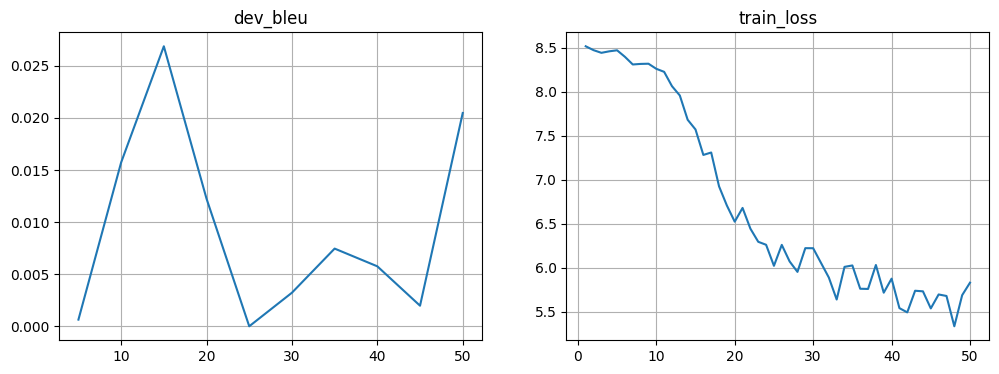

Mean loss=5.628


100%|██████████| 50/50 [04:27<00:00,  5.34s/it]


In [ ]:
for _ in trange(50):
    step = len(metrics['train_loss']) + 1 # текущий шаг обучения
    batch_ix = np.random.randint(len(train_inp), size=batch_size) # выбираем случайный индекс чтобы сформировать случайный пакет данных
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device) 
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad() # обнуляет градиенты для новой итерации
    loss_t = compute_loss(model, batch_inp, batch_out) # значения функции потерь
    loss_t.backward() # вычисляем градиенты
    opt.step() # обновляем параменты модели на основе градиентов с помощью оптимизатора

    metrics['train_loss'].append((step, loss_t.item())) # добавили текущее значение потерь в список

    if step % 5 == 0: # каждые 5 шагов 
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out))) # добавляем значение BLUE

        clear_output(True) # очищает вывод консоли
        plt.figure(figsize=(12,4))
        # строим график для каждой метрики
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)